In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
inline_rc = dict(rcParams)
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import os
import sys
from collections import OrderedDict
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

In [3]:
planets = { '211929937.01': { 'per': 3.476643,
                           'rprs': 0.126,
                           't0': 2309.41227 + 2454833,
                           't14': 0.1}}

star = { 'feh': [0.09, 0.05],
            'logg': [4.53, 0.03],
            'rad': [0.85, 0.02],
            'teff': [5300, 80]}

26
35


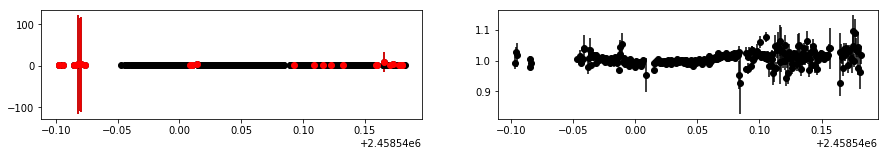

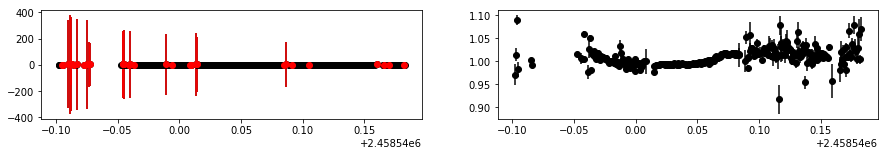

In [70]:
def bin_df(df, binsize_min):
    binsize = binsize_min / (60 * 24)
    bins = np.arange(df['GJD'].min(), df['GJD'].max(), binsize)
    groups = df.groupby(np.digitize(df['GJD'], bins))
    df_binned = groups.mean().copy()
    binfac = df.shape[0] / df_binned.shape[0]
    df_binned['err'] /= np.sqrt(binfac)
    return df_binned

fps = ['../data/epic9937_frac-lc-ID7-comp2_r.dat', '../data/epic9937_frac-lc-ID7-comp2_z.dat']
bands = ['r*','z*']
bandnames = ['r','z']
# t_min, t_max = 2458399.44, 2458399.58
binsize_min = 1

datasets = OrderedDict()
for fp, band, bandname in zip(fps, bands, bandnames):
    names = "GJD-2450000 flux err airmass sky dx dy fwhm peak baserun".split()
    datasets[bandname] = pd.read_csv(fp, names=names, delim_whitespace=True, skiprows=1)
#     datasets[band] = datasets[band].dropna()
    datasets[bandname]['GJD'] = datasets[bandname]['GJD-2450000'] + 2450000

    aux = datasets[bandname]['airmass sky dx dy fwhm peak'.split()].values
    t, f, u = datasets[bandname]['GJD flux err'.split()].values.T

    fig, axs = pl.subplots(1, 2, figsize=(15,2))

    ax = axs[0]
    ax.errorbar(t, f, u, marker='o', linestyle='none', color='k')

    idx = mad_outliers(f)
    print(idx.sum())

    ax.errorbar(t[idx], f[idx], u[idx], marker='o', linestyle='none', color='r')

#     ax.axvline(t_min, color='b')
#     ax.axvline(t_max, color='b')
    
    datasets[bandname] = datasets[bandname][~idx]
    
    if binsize_min is not None:
        datasets[bandname] = bin_df(datasets[bandname], binsize_min)
        
#     t = datasets[band]['BJD_TDB']
#     idx = (t > t_min) & (t < t_max)
#     datasets[band] = datasets[band][idx]

    aux = datasets[bandname]['airmass sky dx dy fwhm peak'.split()].values
    t, f, u = datasets[bandname]['GJD flux err'.split()].values.T

    ax = axs[1]
    ax.errorbar(t, f, u, marker='o', linestyle='none', color='k')

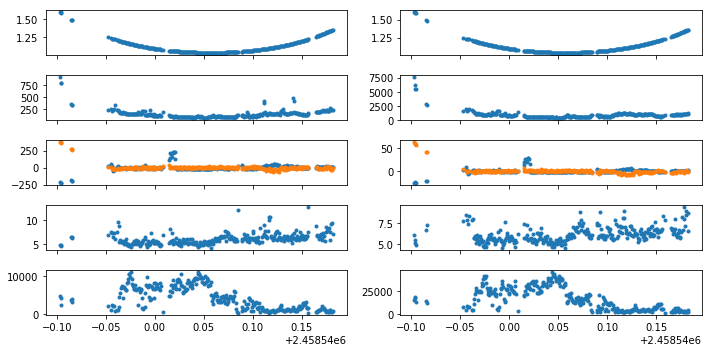

In [76]:
fig, axs = pl.subplots(5, 2, figsize=(10,5), sharex=True)
for i,(bandname,data) in enumerate(datasets.items()):

    time, airmass, sky, cenx, ceny, fwhm, peak = data['GJD airmass sky dx dy fwhm peak'.split()].values.T

    axs[0,i].plot(time, airmass, '.')
    axs[1,i].plot(time, sky, '.')
    axs[2,i].plot(time, cenx/cenx.mean(), '.')
    axs[2,i].plot(time, ceny/ceny.mean(), '.')
    axs[3,i].plot(time, fwhm, '.')
    axs[4,i].plot(time, peak, '.')
    
fig.tight_layout()

In [85]:
teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

from transitfit.util import rho
logg = map_float(star['logg'])
rad = map_float(star['rad'])
n = 10000
rad_s = rad[0] + np.random.randn(n) * rad[1]
logg_s = logg[0] + np.random.randn(n) * logg[1]
rho_s = rho(logg_s, rad_s)
rhop = rho_s.mean(), rho_s.std()

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < t.min():
    t0 += per
    
t0p = t0, 0.001
perp = per, 0.0001
t14p = t14, 0.005

fits = OrderedDict()
for band, bandname in zip(bands, bandnames):
    print("\n{:*^30s}".format(bandname+'-band'))

    ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
    u1, u2 = ldp[0], ldp[2]
    q1, q2 = u_to_q(u1, u2)

    # priors = dict(ld=ldp, rho=rhop)
    # priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
    priors = dict(ld=ldp, t0=t0p, per=perp, rho=rhop)

    aux = datasets[bandname]['airmass sky dx dy fwhm peak'.split()].values
    t, f, u = datasets[bandname]['GJD flux err'.split()].values.T

    init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
    init_params['priors'] = priors
    init_params['ls'] = np.log(f.std())
    
    pp.pprint(init_params)

    fit = TransitFit(init_params, pl_name, t, f, unc=u, aux=aux)
    fits[bandname] = fit


************r-band************
{ 'b': 0.5,
  'k': 0.126,
  'ls': -3.8345498312768598,
  'p': 3.476643,
  'priors': { 'ld': (0.5073, 0.026294875134071288, 0.2089, 0.02362996832581669),
              'per': (3.476643, 0.0001),
              'rho': (2.0566580902693556, 0.1506603205928145),
              't0': (2458540.022755919, 0.001)},
  'q1': 0.5129424399999999,
  'q2': 0.3541608489248813,
  'r': 1.41,
  't0': 2458540.022755919,
  't14': 0.1}

************z-band************
{ 'b': 0.5,
  'k': 0.126,
  'ls': -3.964536552957742,
  'p': 3.476643,
  'priors': { 'ld': (0.2374, 0.0401099267386217, 0.3219, 0.04301256575441065),
              'per': (3.476643, 0.0001),
              'rho': (2.0566580902693556, 0.1506603205928145),
              't0': (2458540.022755919, 0.001)},
  'q1': 0.31281649,
  'q2': 0.21222957268013587,
  'r': 1.41,
  't0': 2458540.022755919,
  't14': 0.1}


In [87]:
for k in fits.keys():
    print("\n{:*^30s}".format(k+'-band'))
    fits[k].fit_map()


************r-band************
Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4585e+06 +/- 0        (0.00%) (init= 2458540)
    p:    3.476643 (fixed)
    k:    0.126 (fixed)
    r:    1.41 (fixed)
    b:    0.66963340 +/- 0        (0.00%) (init= 0.5)
    q1:   0.5129424 (fixed)
    q2:   0.3541608 (fixed)
    ls:  -3.83455 (fixed)
    c0:   0.01543982 +/- 0        (0.00%) (init= 0)
    c1:  -3.0287e-05 +/- 0        (0.00%) (init= 0)
    c2:  -8.6511e-05 +/- 0        (0.00%) (init= 0)
    c3:   5.4525e-05 +/- 0        (0.00%) (init= 0)
    c4:   0.00019393 +/- 0        (0.00%) (init= 0)
    c5:  -4.2208e-07 +/- 0        (0.00%) (init= 0)
None
Transit depth: 15876 [ppm]
Transit duration: 2.50 [h]
Log-probability: 755.4959643466342
True
[[Variables]]
    t0:   2458540 (fixed)
    p:    3.476643 (fixed)
    k:    0.126 (fixed)
    r:    1.41 (fixed)
    b:    0.73057641 (init= 0.6696334)
    q1:   0.5129424 (fixed)
    q2:   0.3541608 (fixed)
    ls:  -3.90368614 (ini

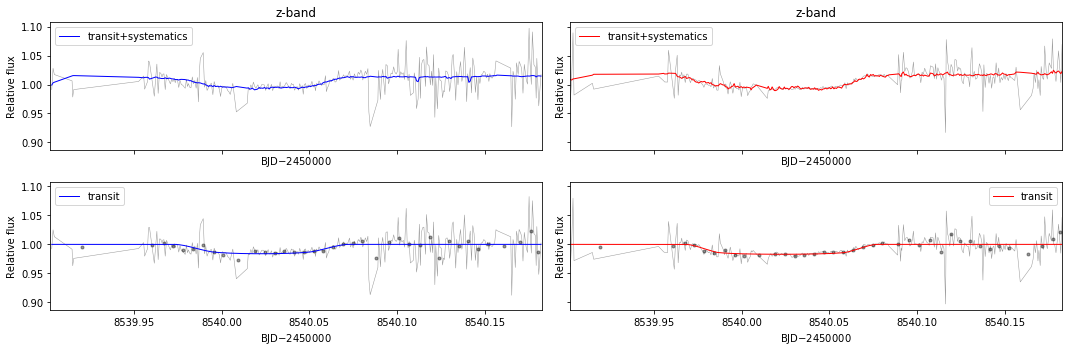

In [89]:
fig, axs = pl.subplots(2, 2, figsize=(15,5), sharex=True, sharey=True)
colors = ['b', 'r']
for i,k in enumerate(fits.keys()):
    c = colors[i]
    fits[k].plot_map(axs=axs[:,i], c1=c, c2=c)
    axs[0,i].set_title('{}-band'.format(band))
    
fig.tight_layout()

In [90]:
for k in fits.keys():
    print("\n{:*^30s}".format(band+'-band'))
    fits[k].fit_mcmc(two_stage=True, steps=1500, nproc=2)


************z-band************
Running stage 1 MCMC (250 steps)...
Running production MCMC for 1500 steps...
[[Variables]]
    t0:   2.4585e+06 +/- 0.000981 (0.00%) (init= 2458540)
    p:    3.47664640 +/- 0.000106 (0.00%) (init= 3.476643)
    k:    0.11545753 +/- 0.020655 (17.89%) (init= 0.126)
    r:    1.91151432 +/- 0.364432 (19.07%) (init= 1.41)
    b:    0.68105318 +/- 0.222018 (32.60%) (init= 0.7305764)
    q1:   0.51327634 +/- 0.046165 (8.99%) (init= 0.5129424)
    q2:   0.35428012 +/- 0.012312 (3.48%) (init= 0.3541608)
    ls:  -3.89411423 +/- 0.035959 (0.92%) (init=-3.903686)
    c0:   0.01553057 +/- 0.008966 (57.74%) (init= 0.01547449)
    c1:  -2.8936e-05 +/- 2.30e-05 (79.58%) (init=-2.965845e-05)
    c2:  -0.00011776 +/- 0.000249 (211.69%) (init=-8.035822e-05)
    c3:   2.1595e-05 +/- 0.000611 (2828.27%) (init= 6.045436e-05)
    c4:   0.00015323 +/- 0.001237 (807.85%) (init= 0.0001703027)
    c5:  -7.8809e-07 +/- 7.20e-07 (91.37%) (init=-5.807732e-07)
None
FIT_MCMC elapse

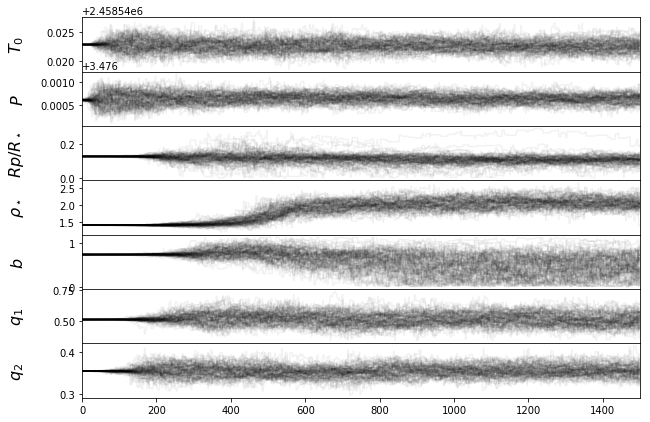

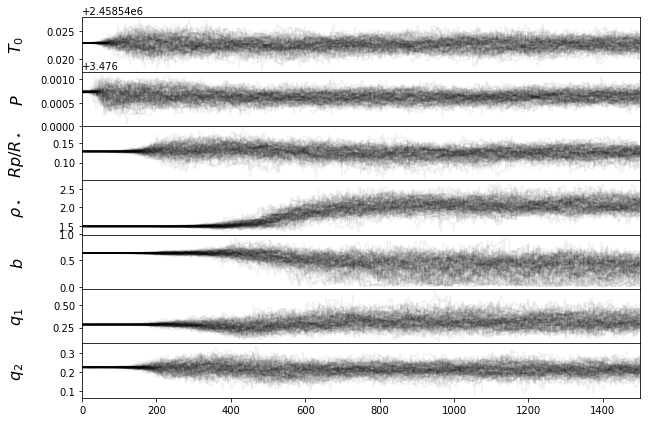

In [91]:
for k in fits.keys():
    fits[k].plot_trace()

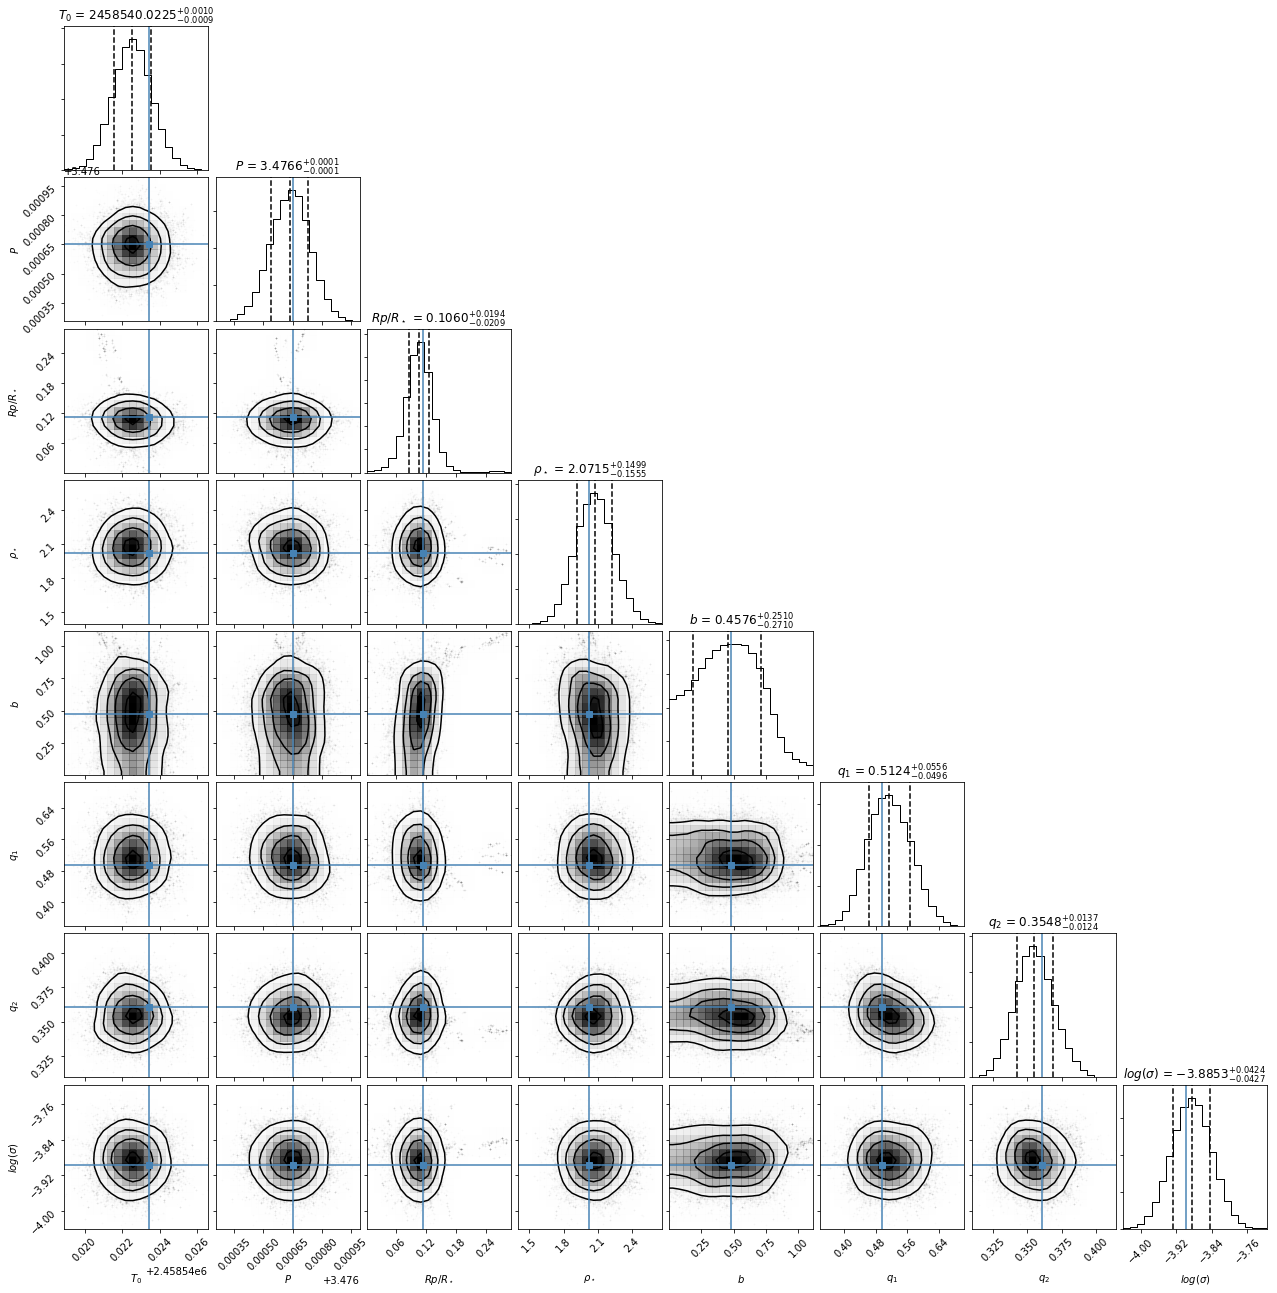

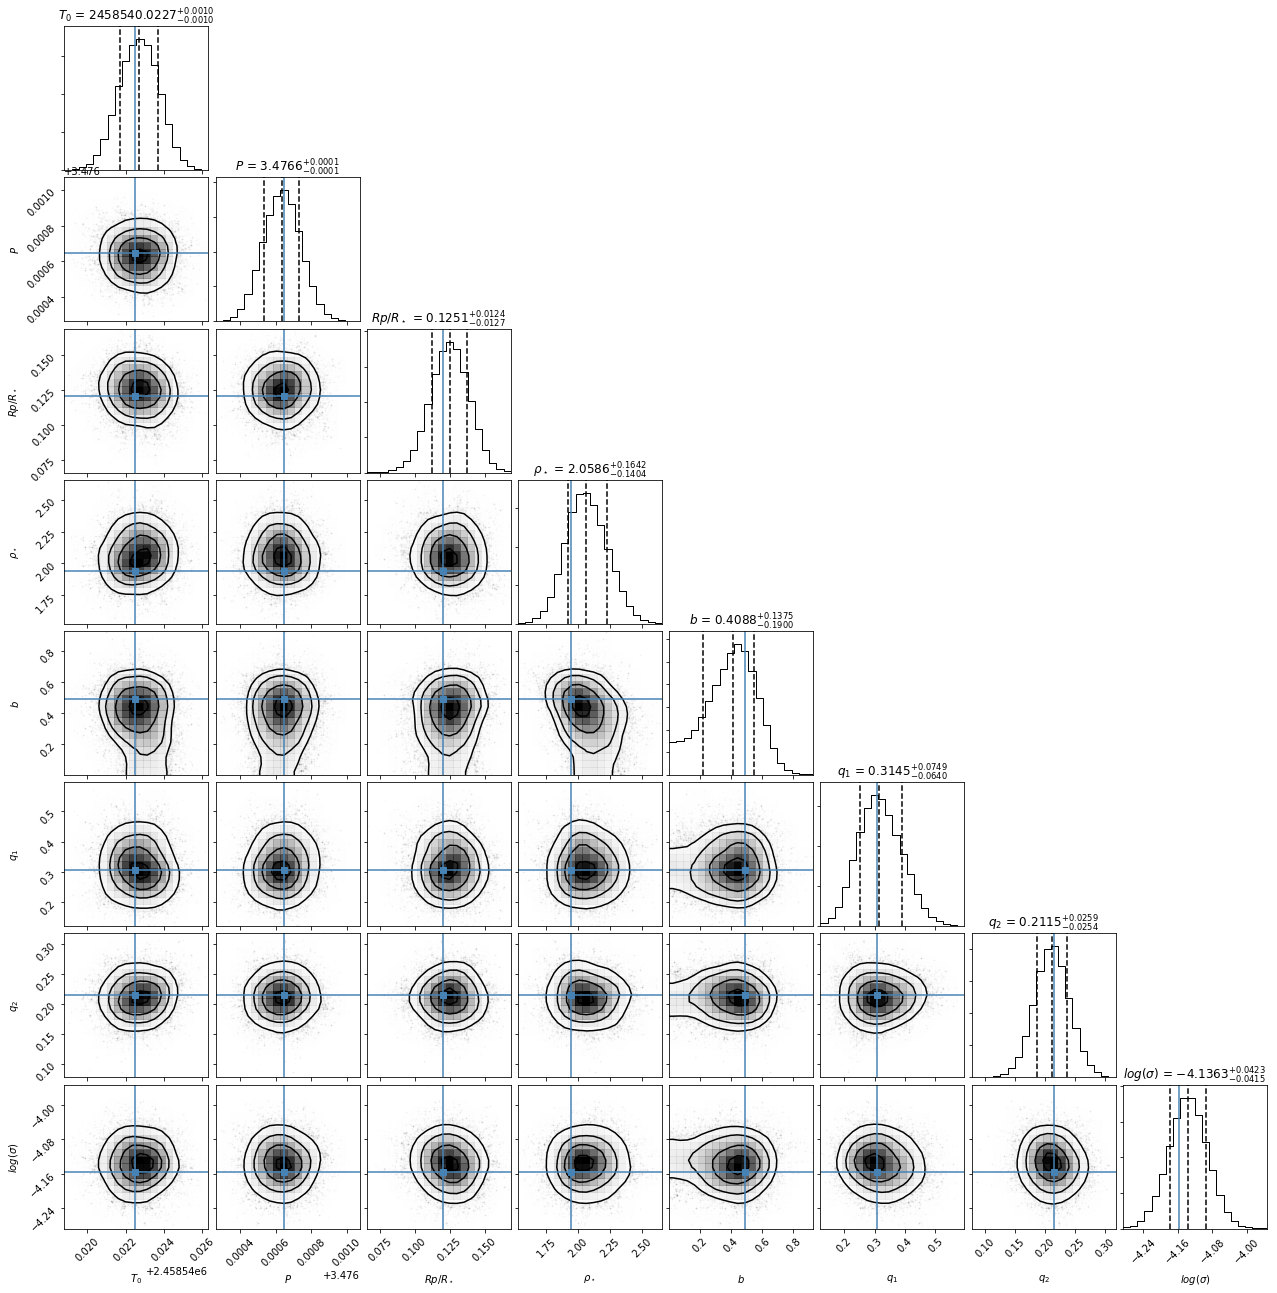

In [92]:
for k in fits.keys():
    fits[k].burn_thin(burn=1000, thin=1)
    fits[k].plot_corner()

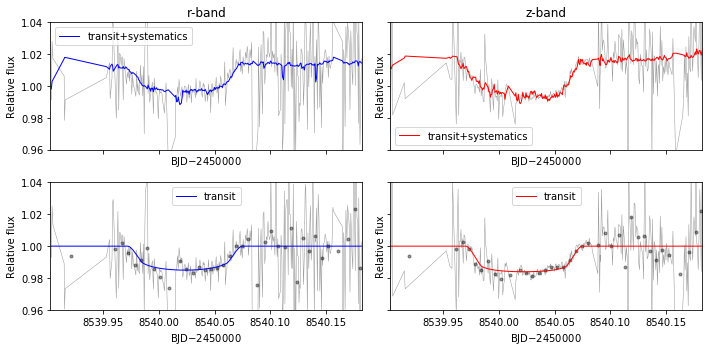

In [93]:
fig, axs = pl.subplots(2, 2, figsize=(10,5), sharex=True, sharey=True)
colors = ['b', 'r']
for i,k in enumerate(fits.keys()):
    c = colors[i]
    fits[k].plot_map(axs=axs[:,i], c1=c, c2=c)
    axs[0,i].set_title('{}-band'.format(k))

pl.setp(axs, ylim=(0.96,1.04))
fig.tight_layout()

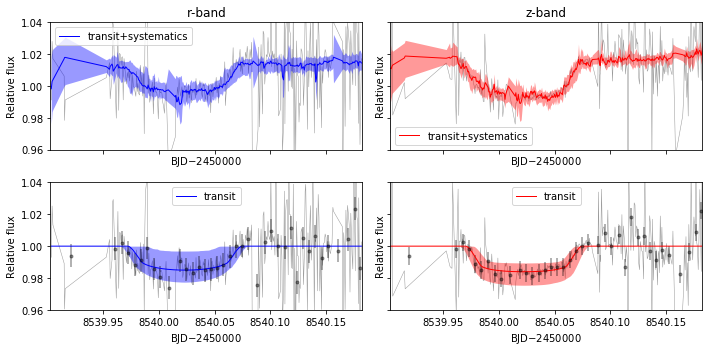

In [94]:
fig, axs = pl.subplots(2, 2, figsize=(10,5), sharex=True, sharey=True)
colors = ['b', 'r']
for i,k in enumerate(fits.keys()):
    c = colors[i]
    fits[k].plot_mcmc(axs=axs[:,i], c1=c, c2=c)
    axs[0,i].set_title('{}-band'.format(k))

pl.setp(axs, ylim=(0.96,1.04))

fig.tight_layout()
fp = '{}-lc.png'.format(pl_name)
fig.savefig(fp, dpi=150)

In [95]:
rad = map_float(star['rad'])
samples = {k:fit.get_df(*rad) for k,fit in fits.items()}

for k,df in samples.items():
    print("\n{:*^30s}".format(k))
#     for key in 'pl_rad inc p t0 t14 t23 shape k max_k rhostar'.split():
    for key in 'pl_rad inc p t0 t14 t23 shape k max_k'.split():
        mu, sig = df[key].median(), df[key].std()
        print('{0: >8}: {1:<10.4f} +/- {2:<10.4f}'.format(key, mu, sig))

../transitfit/util.py:79: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt( (1 - k)**2 - b**2 )



**************r***************
  pl_rad: 9.8208     +/- 2.5118    
     inc: 87.6051    +/- 1.2754    
       p: 3.4766     +/- 0.0001    
      t0: 2458540.0225 +/- 0.0010    
     t14: 0.1013     +/- 0.0124    
     t23: 0.0782     +/- 0.0159    
   shape: 0.7634     +/- 0.1073    
       k: 0.1060     +/- 0.0270    
   max_k: 0.1342     +/- 0.0818    

**************z***************
  pl_rad: 11.5815    +/- 1.2300    
     inc: 87.8655    +/- 0.8580    
       p: 3.4766     +/- 0.0001    
      t0: 2458540.0227 +/- 0.0010    
     t14: 0.1062     +/- 0.0058    
     t23: 0.0782     +/- 0.0083    
   shape: 0.7389     +/- 0.0514    
       k: 0.1251     +/- 0.0129    
   max_k: 0.1502     +/- 0.0374    


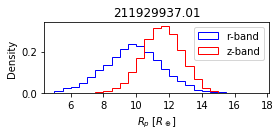

In [97]:
fig, ax = pl.subplots(1, 1, figsize=(4,2))
bins = np.arange(5,18,0.5)
colors = ['b', 'r']
for i,k in enumerate(samples.keys()):
    l = '{}-band'.format(k)
    c = colors[i]
    ax.hist(samples[k]['pl_rad'], bins=bins, histtype='step', label=l, color=c, density=True)
ax.legend()

pl.setp(ax, xlabel=r'$R_p$ [$R_\oplus$]', ylabel='Density', title=pl_name)

fig.tight_layout()
fp = '{}-hist.png'.format(pl_name)
fig.savefig(fp, dpi=150)

In [98]:
import lmfit
from emcee.utils import sample_ball
from transitfit.util import timeit

def get_par(fits):
    par = lmfit.Parameters()

    map_par = list(fits.values())[0].map_par.copy()
    shared_names = 'p t0 r b'.split()
#     shared_names = 'p t0 k a b'.split()
    for na in shared_names:
        k = na + '_s'
        par[k] = map_par[na]

    for band,fit in fits.items():
        map_par = fit.map_par.copy()
        for key in map_par.valuesdict().keys():
            if key not in shared_names:
                k = key + '_{}'.format(band)
                par[k] = map_par[key]
    return par

def log_probability(par, fits):

    p = par.copy()
    lp = 0
    for band,fit in fits.items():
        par = fit.map_par.copy()
        for key in par.valuesdict().keys():
            if key.endswith('_s'):
                k = key.replace('_s','')
                par[k] = p[key]
            elif key.endswith('_{}'.format(band)):
                k = key.replace('_{}'.format(band),'')
                par[k] = p[key]
        lp += fit.log_probability(par)
            
    return lp if np.isfinite(lp) else -np.inf

@timeit
def run_mcmc(par, fits, steps=1000):
    args = (fits,)
#     mini = lmfit.Minimizer(log_probability, par, fcn_args=args, nan_policy='omit')
    mini = lmfit.Minimizer(log_probability, par, fcn_args=args)

    theta = [v for k,v in par.items() if par[k].vary]
    ndim = len(theta)
    nwalkers = 100
    pos0 = sample_ball(theta, [1e-5]*ndim, nwalkers)
    res = mini.emcee(burn=0, steps=steps, thin=1, pos=pos0, workers=1)
    
    return res

# steps = 1500
# burn = 1000
steps = 1000
burn = 500
# steps = 500
# burn = 250
thin = 10
par = get_par(fits)
# par['p_s'].vary = False
log_probability(par, fits)

1600.9913975424865

In [99]:
res = run_mcmc(par, fits, steps=steps)
print(lmfit.fit_report(res.params, show_correl=False))

RUN_MCMC elapsed time: 215 sec
[[Variables]]
    p_s:    3.47655982 +/- 0.204867 (5.89%) (init= 3.476652)
    t0_s:   2.4585e+06 +/- 0.172426 (0.00%) (init= 2458540)
    r_s:    2.01469023 +/- 0.140181 (6.96%) (init= 2.021139)
    b_s:    0.47612890 +/- 0.346052 (72.68%) (init= 0.4760631)
    k_r:    0.11269152 +/- 0.070887 (62.90%) (init= 0.1134916)
    q1_r:   0.49518028 +/- 0.150027 (30.30%) (init= 0.4951244)
    q2_r:   0.37095481 +/- 0.064220 (17.31%) (init= 0.3608153)
    ls_r:  -3.90054465 +/- 0.155010 (3.97%) (init=-3.897098)
    c0_r:   0.02668763 +/- 0.033686 (126.22%) (init= 0.01517996)
    c1_r:   0.01330042 +/- 0.127726 (960.32%) (init=-3.488415e-05)
    c2_r:  -0.00954342 +/- 0.072169 (756.22%) (init=-0.0002292754)
    c3_r:   5.1452e-05 +/- 0.280395 (544965.22%) (init= 4.258091e-06)
    c4_r:   0.01241183 +/- 0.169359 (1364.50%) (init= 0.0004011388)
    c5_r:   0.00448899 +/- 0.032753 (729.64%) (init=-4.900622e-07)
    k_z:    0.12048591 +/- 0.344699 (286.09%) (init= 0.1

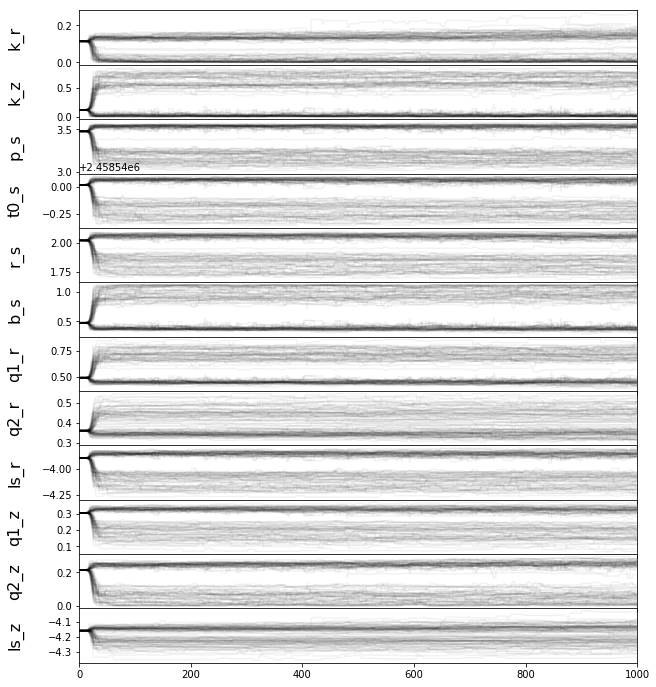

In [100]:
from transitfit.plot import plot_trace
par_names = [k for k,v in par.valuesdict().items() if par[k].vary]

plot_idx = []

for band in fits.keys():
    plot_idx.append(par_names.index('k_{}'.format(band)))

shared = 'p t0 r b'.split()
# shared = 'p t0 k a b'.split()
for pn in shared:
    tn = pn+'_s'
    if tn in par_names:
        plot_idx.append(par_names.index(tn))

for band in fits.keys():
    plot_idx.append(par_names.index('q1_{}'.format(band)))
    plot_idx.append(par_names.index('q2_{}'.format(band)))
    plot_idx.append(par_names.index('ls_{}'.format(band)))

plot_names = np.array(par_names)[plot_idx]
plot_trace(res.chain, plot_names, plot_idx=plot_idx, fp=None)

In [101]:
par

Parameters([('p_s',
             <Parameter 'p_s', value=3.476652208312865 +/- 0.000106, bounds=[0:inf]>),
            ('t0_s',
             <Parameter 't0_s', value=2458540.0234059943 +/- 0.000981, bounds=[-inf:inf]>),
            ('r_s',
             <Parameter 'r_s', value=2.02113886942599 +/- 0.364, bounds=[0:inf]>),
            ('b_s',
             <Parameter 'b_s', value=0.47606310844066246 +/- 0.222, bounds=[0:1.126]>),
            ('k_r',
             <Parameter 'k_r', value=0.11349160618307783 +/- 0.0207, bounds=[0:1]>),
            ('q1_r',
             <Parameter 'q1_r', value=0.49512439124790686 +/- 0.0462, bounds=[0:1]>),
            ('q2_r',
             <Parameter 'q2_r', value=0.36081533432359075 +/- 0.0123, bounds=[0:1]>),
            ('ls_r',
             <Parameter 'ls_r', value=-3.89709822456282 +/- 0.036, bounds=[-10:0]>),
            ('c0_r',
             <Parameter 'c0_r', value=0.015179961674599507 +/- 0.00897, bounds=[-inf:inf]>),
            ('c1_r',
         

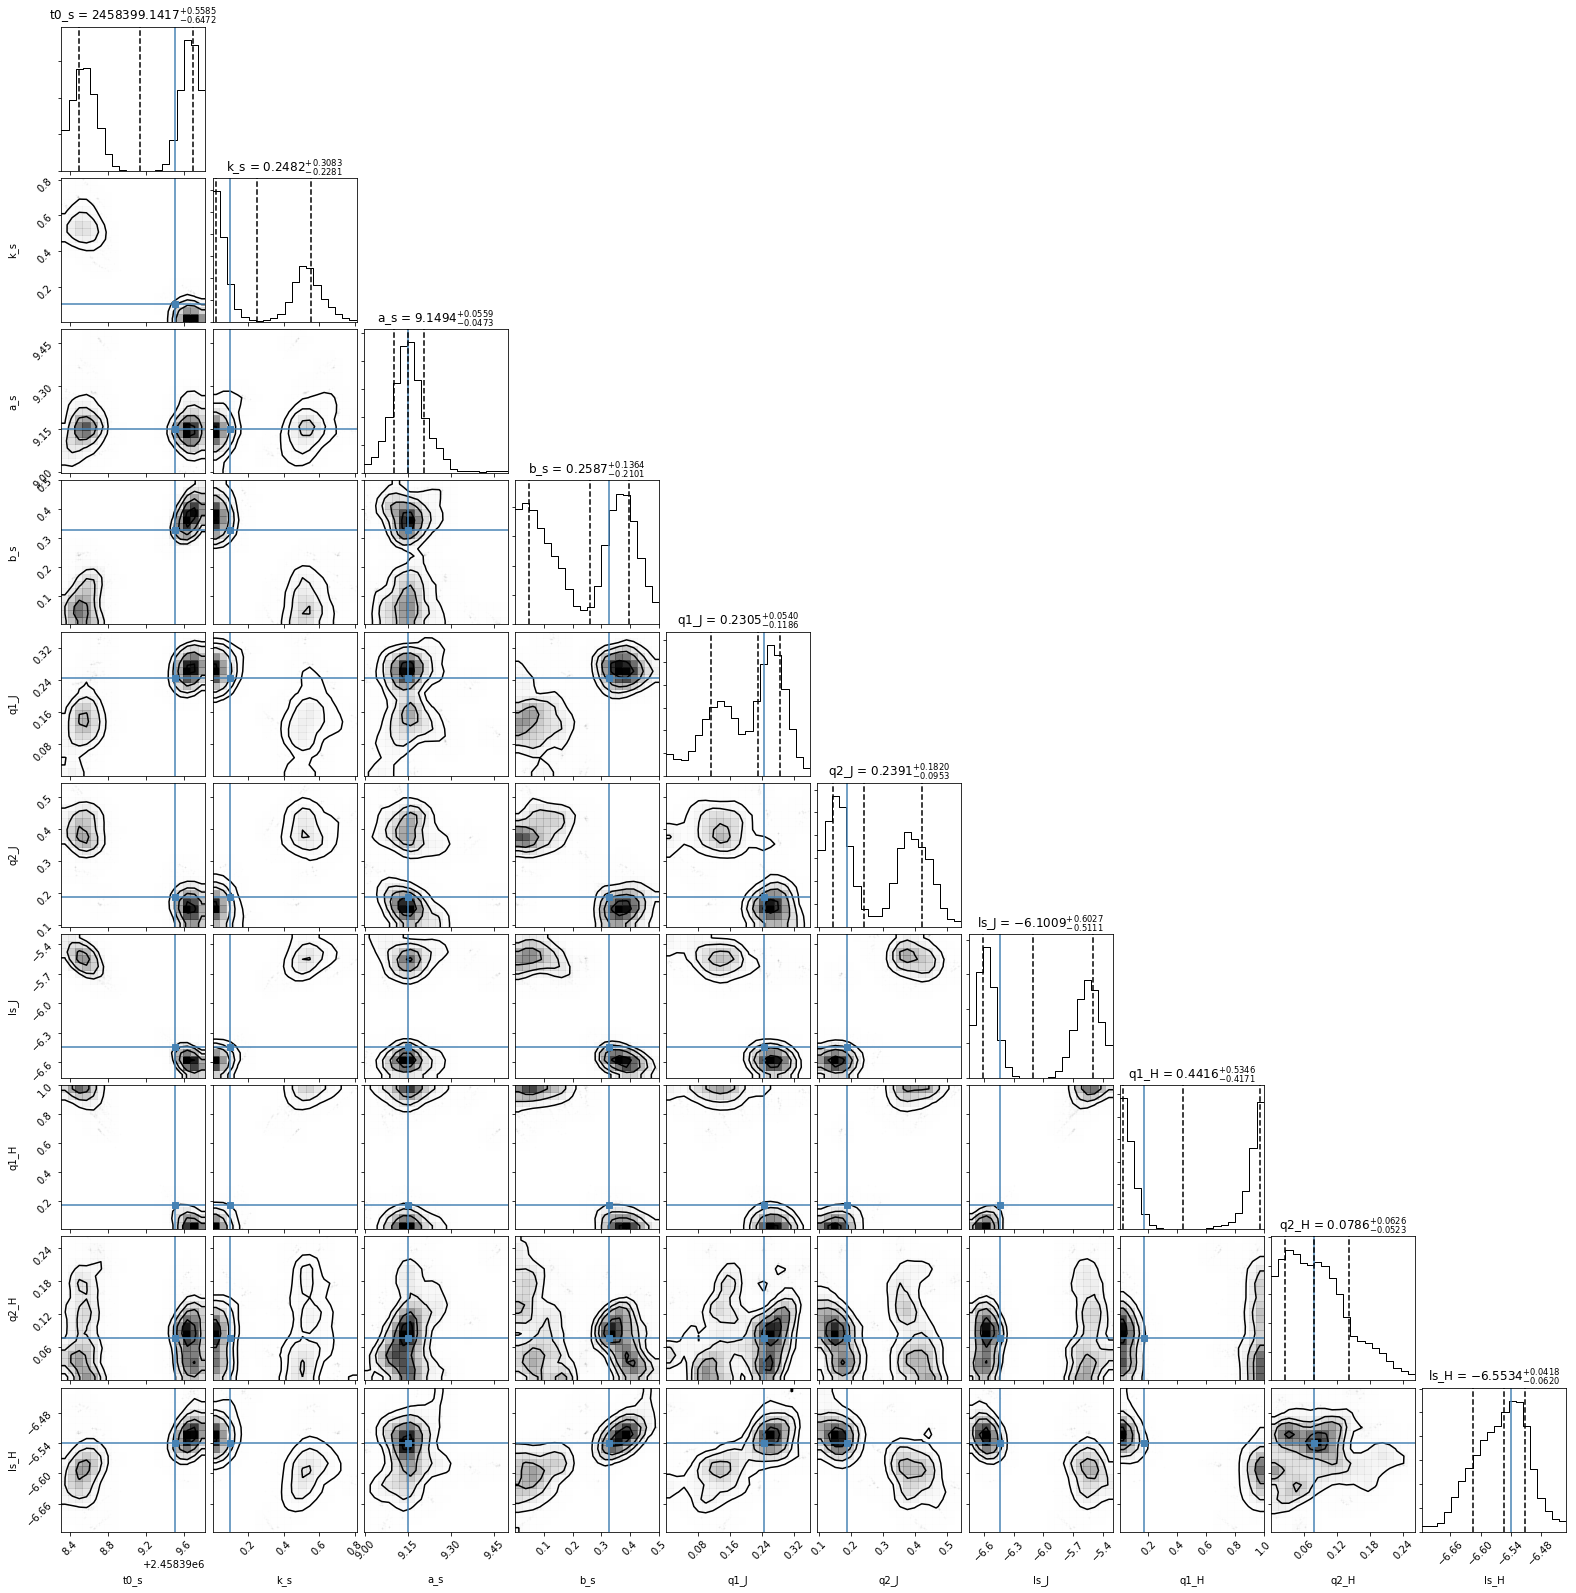

In [63]:
from transitfit.plot import plot_corner

highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
best = res.chain[hp_loc]

nwalkers, nsteps, ndim = res.chain.shape
fc = res.chain[:,burn::thin,:].reshape(-1, ndim)

plot_corner(fc[:,plot_idx], best[plot_idx], np.array(par_names)[plot_idx])

In [47]:
def update_fit(fits, par, fc, best):

    par_names = [k for k,v in par.valuesdict().items() if par[k].vary]
#     shared_names = [pn for pn in par_names if pn.endswith('_s')]

    for band,fit in fits.items():
        # order needs to match the order of parameters in an individual fit
        idx = [par_names.index('t0_s')]
        idx.append(par_names.index('p_s'))
#         idx.append(par_names.index('k_{}'.format(i)))
        idx.append(par_names.index('k_s'))
        idx.append(par_names.index('a_s'))
        idx.append(par_names.index('b_s'))
        idx.append(par_names.index('q1_{}'.format(band)))
        idx.append(par_names.index('q2_{}'.format(band)))
        idx.append(par_names.index('ls_{}'.format(band)))
        # now get the systematics coeffs
        for pn in fit.sm.parameter_names:
            idx.append(par_names.index(pn+'_{}'.format(band)))
        
        fit.fc = fc[:,idx]
        fit.best = best[idx]
        for ix in idx:
            pn = par_names[ix].replace('_s','').replace('_{}'.format(band),'')
            fit.map_par[pn].value = best[ix]

update_fit(fits, par, fc, best)

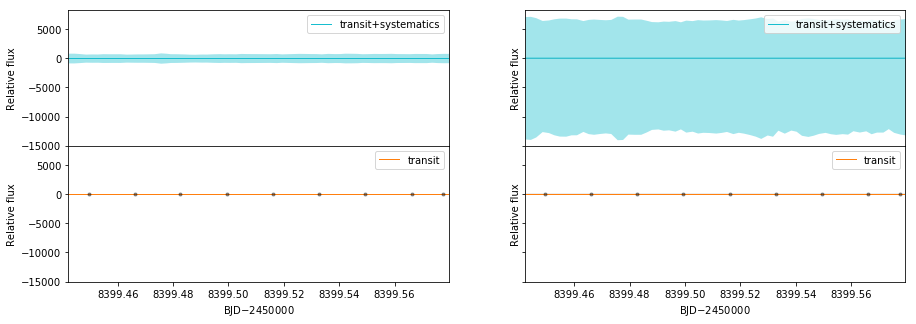

In [48]:
fig, axs = pl.subplots(2, 2, figsize=(15,5), sharex=True, sharey=True)
for i,band in enumerate(fits.keys()):
    fits[band].plot_mcmc(axs=axs[:,i])

In [64]:
rad = map_float(star['rad'])

for band,fit in fits.items():
    df = fit.get_df(*rad)
    print("\n{:*^30s}".format(band))
    for key in 'pl_rad inc p t0 t14 t23 shape k max_k rhostar'.split():
        mu, sig = df[key].median(), df[key].std()
        print('{0: >8}: {1:<10.4f} +/- {2:<10.4f}'.format(key, mu, sig))

NameError: name 'pd' is not defined